In [1]:
import secrets

# import easydict
import matplotlib.pyplot as plt
import torch
# from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
import torch.utils.data as data
from tqdm import tqdm
import pandas as pd
import numpy as np

# from model import LSTMVAE
from numpy import recarray
from sklearn.model_selection import train_test_split
# from dataset import mHealth
from torchvision import transforms
import torch.utils.data as data

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
class mHealth(data.Dataset):

    def __init__(self, dataframe, raw_data):
        """
        Args:
            csv_file (string): path to csv file with data
        """
        self.dataset = dataframe
        self.raw_data = raw_data

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        """
        Args:
            index (int): index

        Returns:
            (sequence, label)
            returns the time series data then label value for data
        """

        # label = self.raw_data['label'].iloc[index]

        # sequence = np.array()
        # print(self.dataset['chest acceleration X-axis'].iloc[index:index+32].type)
        # sequence = [self.dataset['chest acceleration X-axis'].iloc[index:index+32],
        #             self.dataset['chest acceleration Y-axis'].iloc[index:index+32],
        #             self.dataset['chest acceleration Z-axis'].iloc[index:index+32],]

        # sequence = [self.dataset['Chest X-axis'].iloc[index],
        #             self.dataset['Chest Y-axis'].iloc[index],
        #             self.dataset['Chest Z-axis'].iloc[index],]

        sequence = torch.tensor(self.dataset[index:index+16]).type(torch.float32)
        target = torch.tensor(self.dataset[index+17:index+32]).type(torch.float32)

        # if(len(sequence) <14):
        #     print("sequence is small, index: ", index)


        # print(sequence.type)
        return sequence, target

def collate_fn(batch):
    # Get the maximum length in the batch
    max_length = max(len(x[0]) for x in batch)
    # print("maxlangth=", max_length)

    # Pad all sequences to the maximum length
    padded_y_batch = []
    padded_x_batch = []
    for x,y in batch:
        padded_x = torch.cat([x, torch.zeros(max_length - len(x))], dim=0)
        padded_y = torch.cat([y, torch.zeros(max_length - len(y))], dim=0)
        padded_x_batch.append((padded_x))
        padded_y_batch.append((padded_y))


    padded_x_batch = torch.stack(padded_x_batch)
    padded_y_batch = torch.stack(padded_y_batch)

    return padded_x_batch, padded_y_batch
#create new dataframe with each index ho lding the 32 values in the future

In [3]:
import torch
from torch import nn
from torch.nn import functional as F


class Encoder(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bidirectional=False,
        )

    def forward(self, x):
        # x: tensor of shape (batch_size, seq_length, hidden_size)
        # x = x.view(*x.shape, 64)
        x = x.unsqueeze(dim=0)
        x = x.permute(1, 2, 0)
        # print("encoder x shape: ", x.shape)
        outputs, (hidden, cell) = self.lstm(x)
        # print("failed")
        # print("enc output shape: ", outputs.shape)
        return outputs, (hidden, cell)


class Decoder(nn.Module):
    def __init__(
        self, input_size=1, hidden_size=64, output_size=1, num_layers=2
    ):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bidirectional=False,
        )
        self.fc = nn.Linear(hidden_size,
                            output_size)

    def forward(self, x, hidden):
        x = x.reshape(512, 1, 64)
        hidden = (hidden[0].unsqueeze(dim=0), hidden[1].unsqueeze(dim=0))
        # hidden = (hidden[0].permute(0, 1, 2), hidden[1].permute(1, 2,0))
        # print("hidden shape 0: ", hidden[0].shape)
        # print("hidden shape 1: ", hidden[1].shape)
        # print("decoder x shape: ", x.shape)
        # x: tensor of shape (batch_size, seq_length, hidden_size)

        # print()
        output, (hidden, cell) = self.lstm(x, hidden)
        # print("got here")
        prediction = self.fc(output)
        return prediction, (hidden, cell)


class LSTMVAE(nn.Module):
    """LSTM-based Variational Auto Encoder"""

    def __init__(
        self, input_size, hidden_size, latent_size, device
    ):
        """
        input_size: int, batch_size x sequence_length x input_dim
        hidden_size: int, output size of LSTM AE
        latent_size: int, latent z-layer size
        num_lstm_layer: int, number of layers in LSTM
        """
        super(LSTMVAE, self).__init__()
        self.device = device

        # dimensions
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.num_layers = 1

        # lstm ae
        self.lstm_enc = Encoder(
            input_size=1,
            hidden_size=hidden_size,
            num_layers=self.num_layers
        )

        self.lstm_dec = Decoder(
            input_size=64,
            output_size=16,
            hidden_size=hidden_size,
            num_layers=self.num_layers,
        )

        self.fc21 = nn.Linear(self.hidden_size, self.latent_size) #expected input: [64, 0]
        self.fc22 = nn.Linear(self.hidden_size, self.latent_size)
        self.fc3 = nn.Linear(self.latent_size, self.hidden_size)

    def reparametize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        noise = torch.randn_like(std).to(self.device)

        z = mu + noise * std
        return z

    def forward(self, x):
        x = x.squeeze()
        # print("x shape: ", x.shape)
        batch_size, seq_len = x.shape
        feature_dim = 1

        # encode input space to hidden space
        outputs, enc_hidden = self.lstm_enc(x)
        # print("enc out shape: ", outputs.shape)
        # print("enchidden 0 shape: ", enc_hidden[0].shape)
        # print("enchidden 1 shape: ", enc_hidden[1].shape)
        # print("got here line 99")

        # enc_h = enc_hidden[0].view(self.hidden_size).to(self.device)
        enc_h = enc_hidden[0].view(batch_size, self.hidden_size).to(self.device)
        # print("passed")
        # print("enc_h shape: ", enc_h.shape)
        # extract latent variable z(hidden space to latent space)
        mean = self.fc21(enc_h)
        logvar = self.fc22(enc_h)
        z = self.reparametize(mean, logvar)  # batch_size x latent_size

        # initialize hidden state as inputs
        # print("latent to hidden shape: ", z.shape)
        h_ = self.fc3(z)

        # decode latent space to input space
        z = z.repeat(1, seq_len, 1)
        # z = z.view(batch_size, seq_len, self.latent_size).to(self.device)
        z = z.view(batch_size, seq_len, self.latent_size).to(self.device)
        # print("z shape:", z.shape)
        # initialize hidden state
        hidden = (h_.contiguous(), h_.contiguous())
        # print("hiddem shape", hidden[0].shape)
        # print("hiddem shape", hidden[1].shape)
        # print("got here 2")
        reconstruct_output, hidden = self.lstm_dec(z, hidden)
        # print("reconstruction output shape: ", reconstruct_output.shape)
        # print("hidden shape [0]: ", hidden[0].shape)
        # print("hidden shape [1]: ", hidden[1].shape)
        # print("reconstruct_output shape:", reconstruct_output.shape)
        x_hat = reconstruct_output.squeeze()
        # print("reconstruct_output shape:", x_hat.shape)
        # calculate vae loss
        # print(x.shape)
        losses = self.loss_function(x_hat, x, mean, logvar)
        m_loss, recon_loss, kld_loss = (
            losses["loss"],
            losses["Reconstruction_Loss"],
            losses["KLD"],
        )

        return m_loss, x_hat, (recon_loss, kld_loss)

    def loss_function(self, *args, **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = 0.00025  # Account for the minibatch samples from the dataset

        # recons = recons.reshape(4, 16)
        # recons = recons.reshape(64, 512, 1)
        # print("recons shape: ", recons.shape)
        # print("input shape: ", input.shape)
        recons_loss = F.mse_loss(recons, input)

        kld_loss = torch.mean(
            -0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp(), dim=1), dim=0
        )

        loss = recons_loss + kld_weight * kld_loss
        return {
            "loss": loss,
            "Reconstruction_Loss": recons_loss.detach(),
            "KLD": -kld_loss.detach(),
        }

    # def loss_function(recon_x, x, mu, logvar):
    #     BCE = torch.nn.functional.mse_loss(recon_x, x, reduction='sum')
    #     KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    #     return BCE + KLD


# class LSTMAE(nn.Module):
#     """LSTM-based Auto Encoder"""

#     def __init__(self, input_size, hidden_size, latent_size, device):
#         """
#         input_size: int, batch_size x sequence_length x input_dim
#         hidden_size: int, output size of LSTM AE
#         latent_size: int, latent z-layer size
#         num_lstm_layer: int, number of layers in LSTM
#         """
#         super(LSTMAE, self).__init__()
#         self.device = device

#         # dimensions
#         self.input_size = input_size
#         self.hidden_size = hidden_size
#         self.latent_size = latent_size

#         # lstm ae
#         self.lstm_enc = Encoder(
#             input_size=input_size,
#             hidden_size=hidden_size,
#         )
#         self.lstm_dec = Decoder(
#             input_size=input_size,
#             output_size=input_size,
#             hidden_size=hidden_size,
#         )

#         self.criterion = nn.MSELoss()

#     def forward(self, x):
#         batch_size, seq_len, feature_dim = x.shape

#         enc_hidden = self.lstm_enc(x)

#         temp_input = torch.zeros((batch_size, seq_len, feature_dim), dtype=torch.float).to(
#             self.device
#         )
#         hidden = enc_hidden
#         reconstruct_output, hidden = self.lstm_dec(temp_input, hidden)
#         reconstruct_loss = self.criterion(reconstruct_output, x)

#         return reconstruct_loss, reconstruct_output, (0, 0)

<>:166: SyntaxWarning: invalid escape sequence '\m'
<>:166: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_2639/2348859798.py:166: SyntaxWarning: invalid escape sequence '\m'
  """


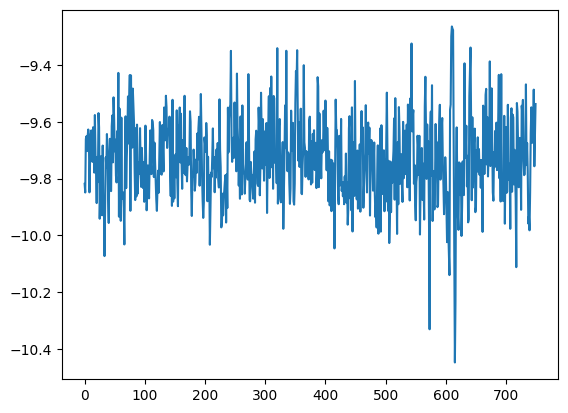

In [4]:
dataset = pd.read_csv('/home/jm/vscode/Python/pythonenv/gait-project/datasets/MHEALTHDATASET_CSV/mHealth_subject1.csv')
dataset = dataset['chest acceleration X-axis']
plt.plot(dataset[:750])

In [5]:
dataset = torch.tensor(dataset)
dataset.shape

torch.Size([161280])

In [6]:
LOAD_MODEL = False
split_idx = int(len(dataset) * 0.8)

# training dataset
train_set = mHealth(
    dataframe=dataset[:split_idx],
    raw_data=dataset
)

test_set = mHealth(
    dataframe=dataset[split_idx:],
    raw_data=dataset
)

batch_size = 512
input_size = 16
hidden_size = 64
latent_size = 4
num_layers = 2

# if torch.cuda.is_available():
#     device = 'cuda'
#     print("cuda")
# else:
device = 'cpu'
print("cpu")

if(LOAD_MODEL):
    model = LSTMVAE(input_size, hidden_size, latent_size, device=device)
    model.load_state_dict(torch.load('C:\\Users\Admin\\.vscode\PyTorch\\lstm_vae\\model'))
else:
    # define LSTM-based VAE model
    model = LSTMVAE(input_size, hidden_size, latent_size, device=device)

cpu


<>:30: SyntaxWarning: invalid escape sequence '\A'
<>:30: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipykernel_2639/3901390549.py:30: SyntaxWarning: invalid escape sequence '\A'
  model.load_state_dict(torch.load('C:\\Users\Admin\\.vscode\PyTorch\\lstm_vae\\model'))


In [7]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True
)

print(f"Dataloaders: {train_loader}")
print(f"Length of train_dataloader: {len(train_loader)} batches of {batch_size}")

# test_loader = torch.utils.data.DataLoader(
#     dataset=test_set,
#     batch_size=args.batch_size,
#     shuffle=False,
#     drop_last=True
# )

for idx, data in enumerate(train_loader):
    datas = data[0]
    labels = data[1]
    print(datas)
    break
    print("Data shape:", datas.shape)
    #print("Labels:", labels)
   # ("Labels shape:", len(labels))
    print("labels shape", labels.shape)
    break

Dataloaders: <torch.utils.data.dataloader.DataLoader object at 0x773f235c6ae0>
Length of train_dataloader: 252 batches of 512
tensor([[ -9.5897,  -9.7348,  -9.7268,  ...,  -9.6424,  -9.8789,  -9.7360],
        [-21.4490, -18.9700, -15.5560,  ...,  -2.4469,  -9.8787, -21.8840],
        [-12.8390, -13.8010, -13.5760,  ...,  -9.5329,  -9.0762,  -8.6513],
        ...,
        [ -9.3995,  -9.4164,  -9.3811,  ...,  -9.5116,  -9.3833,  -9.6162],
        [ -8.6736,  -8.8133,  -8.9274,  ...,  -9.2401,  -8.7921,  -8.6828],
        [ -9.9481,  -9.8440,  -9.9439,  ..., -10.3600,  -9.7252,  -9.4157]])


/tmp/ipykernel_2639/886190181.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequence = torch.tensor(self.dataset[index:index+16]).type(torch.float32)
/tmp/ipykernel_2639/886190181.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(self.dataset[index+17:index+32]).type(torch.float32)


In [8]:
train_loss = []
test_loss = []

def train(iterations, model, train_loader, test_loader):
    # optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

    ## interation setup
    epochs = tqdm(range(iterations))

    ## training
    count = 0
    for epoch in epochs:
        model.train()
        optimizer.zero_grad()
        train_iterator = tqdm(
            enumerate(train_loader), total=len(train_loader)-32, desc="training"
        )

        for i, batch_data in train_iterator:

            if count > iterations:
                return model
            count += 1

            past_data, future_data = batch_data

            mloss, recon_x, info = model(past_data)

            # Backward and optimize
            optimizer.zero_grad()
            mloss.mean().backward()
            optimizer.step()

            train_iterator.set_postfix({"train_loss": float(mloss.mean())})
            train_loss.append(float(mloss.mean()))


        model.eval()
        eval_loss = 0
        test_iterator = tqdm(
            enumerate(test_loader), total=len(test_loader), desc="testing"
        )

        with torch.no_grad():
            for i, batch_data in test_iterator:
                future_data, past_data = batch_data

                ## reshape
                batch_size = past_data.size(0)
                example_size = past_data.size(1)
                past_data = (
                    past_data.view(batch_size, example_size, -1).float().to(device)
                )

                mloss, recon_x, info = model(past_data)

                eval_loss += mloss.mean().item()

                test_iterator.set_postfix({"eval_loss": float(mloss.mean())})
                test_loss.append(float(mloss.mean()))

        eval_loss = eval_loss / len(test_loader)
        # writer.add_scalar("eval_loss", float(eval_loss), epoch)
        print("Evaluation Score : [{}]".format(eval_loss))

    return model


In [12]:
iterations = 10000
train(iterations, model, train_loader, train_loader)
torch.save(model.state_dict(), '/home/jm/vscode/Python/pythonenv/gait-project/VAE+RNN/lstm_vae/model_state_dict')

  0%|          | 0/10000 [00:00<?, ?it/s]/tmp/ipykernel_2639/886190181.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequence = torch.tensor(self.dataset[index:index+16]).type(torch.float32)
/tmp/ipykernel_2639/886190181.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(self.dataset[index+17:index+32]).type(torch.float32)
training: 252it [00:09, 27.80it/s, train_loss=3.05]
  0%|          | 1/10000 [00:14<40:50:52, 14.71s/it]

Evaluation Score : [8.386869299979438]


training: 252it [00:08, 28.41it/s, train_loss=3.22]
  0%|          | 2/10000 [00:29<40:20:53, 14.53s/it]

Evaluation Score : [8.194963076758006]


training: 252it [00:08, 28.58it/s, train_loss=2.69]
  0%|          | 3/10000 [00:43<40:16:03, 14.50s/it]

Evaluation Score : [7.750446957255167]


training: 252it [00:09, 27.99it/s, train_loss=3]
  0%|          | 4/10000 [00:58<40:27:03, 14.57s/it]

Evaluation Score : [7.751836209070115]


training: 252it [00:09, 27.72it/s, train_loss=2.99]
  0%|          | 5/10000 [01:12<40:35:04, 14.62s/it]

Evaluation Score : [8.631559018104795]


training: 252it [00:08, 28.22it/s, train_loss=2.58]
  0%|          | 6/10000 [01:27<40:26:23, 14.57s/it]

Evaluation Score : [7.751995737590487]


training: 252it [00:09, 27.86it/s, train_loss=3.19]
  0%|          | 7/10000 [01:42<40:28:38, 14.58s/it]

Evaluation Score : [8.10476961968437]


training: 252it [00:09, 27.16it/s, train_loss=2.29]
  0%|          | 8/10000 [01:57<40:51:58, 14.72s/it]

Evaluation Score : [7.9573252276768764]


training: 252it [00:09, 27.27it/s, train_loss=2.42]
  0%|          | 9/10000 [02:12<41:07:37, 14.82s/it]

Evaluation Score : [7.402767781227354]


training: 252it [00:09, 27.46it/s, train_loss=2.6]
  0%|          | 10/10000 [02:26<41:10:04, 14.84s/it]

Evaluation Score : [7.773750108385843]


training: 252it [00:09, 26.93it/s, train_loss=2.72]
  0%|          | 11/10000 [02:42<41:20:08, 14.90s/it]

Evaluation Score : [8.05180111196306]


training: 252it [00:09, 26.97it/s, train_loss=2.07]
  0%|          | 12/10000 [02:57<41:28:45, 14.95s/it]

Evaluation Score : [7.686672645901877]


training: 252it [00:09, 27.01it/s, train_loss=1.89]
  0%|          | 13/10000 [03:12<41:33:43, 14.98s/it]

Evaluation Score : [7.82773971179175]


training: 252it [00:09, 27.42it/s, train_loss=2.13]
  0%|          | 14/10000 [03:27<41:28:45, 14.95s/it]

Evaluation Score : [7.213718168319217]


training: 252it [00:09, 27.37it/s, train_loss=2.2]
  0%|          | 15/10000 [03:41<41:25:21, 14.93s/it]

Evaluation Score : [7.8435577797511264]


training: 252it [00:09, 27.56it/s, train_loss=2.31]
  0%|          | 16/10000 [03:56<41:18:55, 14.90s/it]

Evaluation Score : [7.222939016327025]


training: 252it [00:09, 27.14it/s, train_loss=2.67]
  0%|          | 17/10000 [04:11<41:22:04, 14.92s/it]

Evaluation Score : [7.305177514515226]


training: 252it [00:09, 26.83it/s, train_loss=1.78]
  0%|          | 18/10000 [04:26<41:30:05, 14.97s/it]

Evaluation Score : [7.541228674706959]


training: 252it [00:09, 27.21it/s, train_loss=2.08]
  0%|          | 19/10000 [04:41<41:30:59, 14.97s/it]

Evaluation Score : [7.158675468157208]


training: 252it [00:09, 27.45it/s, train_loss=2.13]
  0%|          | 20/10000 [04:56<41:28:07, 14.96s/it]

Evaluation Score : [7.363065072468349]


training: 252it [00:09, 27.03it/s, train_loss=2.02]
  0%|          | 21/10000 [05:11<41:33:37, 14.99s/it]

Evaluation Score : [7.349015345649113]


training: 252it [00:09, 27.11it/s, train_loss=2.32]
  0%|          | 22/10000 [05:26<41:36:11, 15.01s/it]

Evaluation Score : [7.014523167458791]


training: 252it [00:09, 27.24it/s, train_loss=1.87]
  0%|          | 23/10000 [05:41<41:38:17, 15.02s/it]

Evaluation Score : [6.615350957900759]


training: 252it [00:09, 27.27it/s, train_loss=1.82]
  0%|          | 24/10000 [05:56<41:33:31, 15.00s/it]

Evaluation Score : [6.811582342026726]


training: 252it [00:09, 27.51it/s, train_loss=1.94]
  0%|          | 25/10000 [06:11<41:29:02, 14.97s/it]

Evaluation Score : [6.527445829103863]


training: 252it [00:09, 27.40it/s, train_loss=1.65]
  0%|          | 26/10000 [06:26<41:22:06, 14.93s/it]

Evaluation Score : [6.47829006020985]


training: 252it [00:09, 27.40it/s, train_loss=2.08]
  0%|          | 27/10000 [06:41<41:24:22, 14.95s/it]

Evaluation Score : [6.897362657955715]


training: 252it [00:09, 27.24it/s, train_loss=1.93]
  0%|          | 28/10000 [06:56<41:27:21, 14.97s/it]

Evaluation Score : [6.58247877491845]


training: 252it [00:09, 27.18it/s, train_loss=1.74]
  0%|          | 29/10000 [07:11<41:25:36, 14.96s/it]

Evaluation Score : [6.220356808768378]


training: 252it [00:09, 27.40it/s, train_loss=1.76]
  0%|          | 30/10000 [07:26<41:22:15, 14.94s/it]

Evaluation Score : [6.458752459949917]


training: 252it [00:09, 27.39it/s, train_loss=1.82]
  0%|          | 31/10000 [07:41<41:16:42, 14.91s/it]

Evaluation Score : [6.60241985510266]


training: 252it [00:09, 27.55it/s, train_loss=1.68]
  0%|          | 32/10000 [07:56<41:18:42, 14.92s/it]

Evaluation Score : [6.377002787968469]


training: 252it [00:09, 27.23it/s, train_loss=1.93]
  0%|          | 33/10000 [08:11<41:23:54, 14.95s/it]

Evaluation Score : [6.219781894532461]


training: 252it [00:09, 27.33it/s, train_loss=2.02]
  0%|          | 34/10000 [08:26<41:19:44, 14.93s/it]

Evaluation Score : [6.165088702761937]


training: 252it [00:09, 27.29it/s, train_loss=1.62]
  0%|          | 35/10000 [08:41<41:20:24, 14.93s/it]

Evaluation Score : [6.597865674230787]


training: 252it [00:09, 27.44it/s, train_loss=1.71]
  0%|          | 36/10000 [08:55<41:19:15, 14.93s/it]

Evaluation Score : [6.221596757570903]


training: 252it [00:09, 26.89it/s, train_loss=2.06]
  0%|          | 37/10000 [09:11<41:28:40, 14.99s/it]

Evaluation Score : [6.733596493327428]


training: 252it [00:09, 26.60it/s, train_loss=1.63]
  0%|          | 38/10000 [09:26<41:33:16, 15.02s/it]

Evaluation Score : [6.171732194839962]


training: 252it [00:09, 27.01it/s, train_loss=2.13]
  0%|          | 39/10000 [09:41<41:32:33, 15.01s/it]

Evaluation Score : [6.15112751060062]


  0%|          | 39/10000 [09:47<41:40:19, 15.06s/it]


In [14]:
def predict(model, dataloader):
    model.eval()
    all_outputs = []
    with torch.no_grad():
        for i, batch in dataloader:
            # print(batch.shape)
            x = batch  # Assuming batch is a tuple (data, target), adjust if necessary

            ## reshape
            batch_size = x.size(0)
            example_size = x.size(1)
            x = (
                x.view(batch_size, example_size, -1).float().to(device)
            )

            mloss, recon_x, info = model(x)
            all_outputs.append(recon_x)
    return torch.cat(all_outputs, dim=0)

/tmp/ipykernel_2639/886190181.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequence = torch.tensor(self.dataset[index:index+16]).type(torch.float32)
/tmp/ipykernel_2639/886190181.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(self.dataset[index+17:index+32]).type(torch.float32)


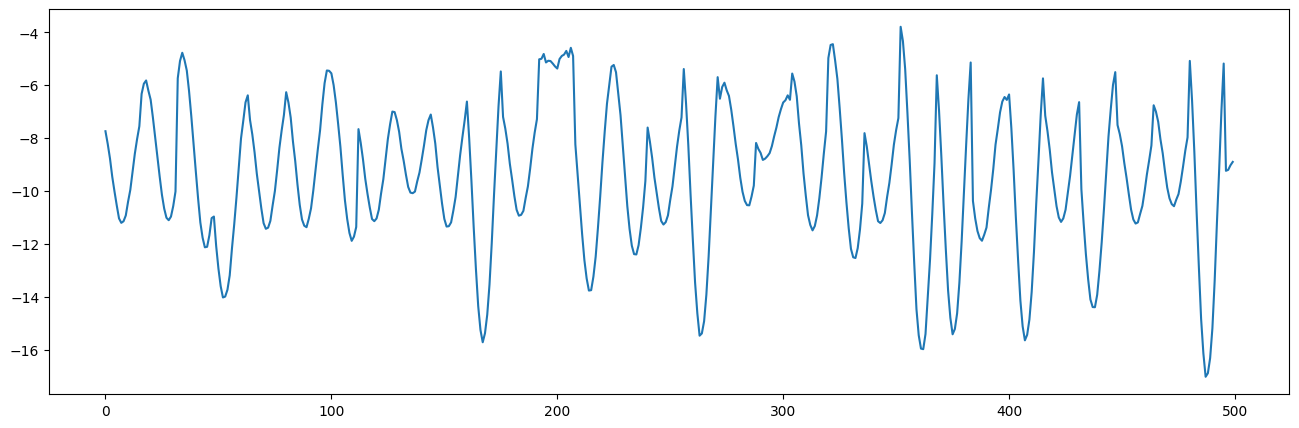

In [15]:
reconstruction = predict(model, test_loader)
reconstruction = reconstruction.reshape(516096, 1)
reconstruction = reconstruction.squeeze()
reconstruction = reconstruction.cpu().numpy()

plt.figure(figsize=(16,5))
plt.plot(reconstruction[:500])
# plt.plot(dataset[:750])
# plt.legend(["Test series ", "Reconstructed test series "])
# plt.ylabel("Acceleration value")
# plt.xlabel("Timestep")

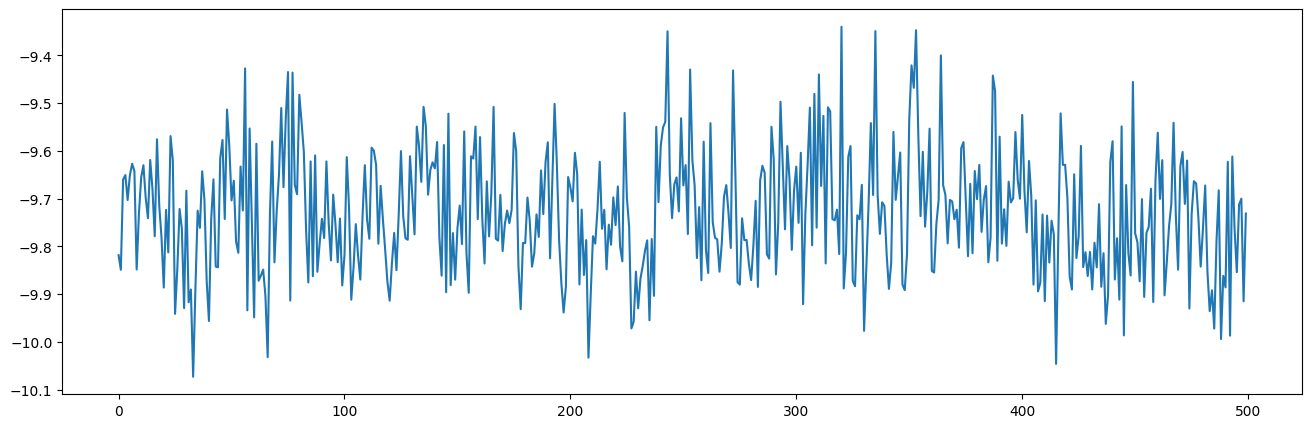

In [16]:
plt.figure(figsize=(16,5))
plt.plot(dataset[:500])

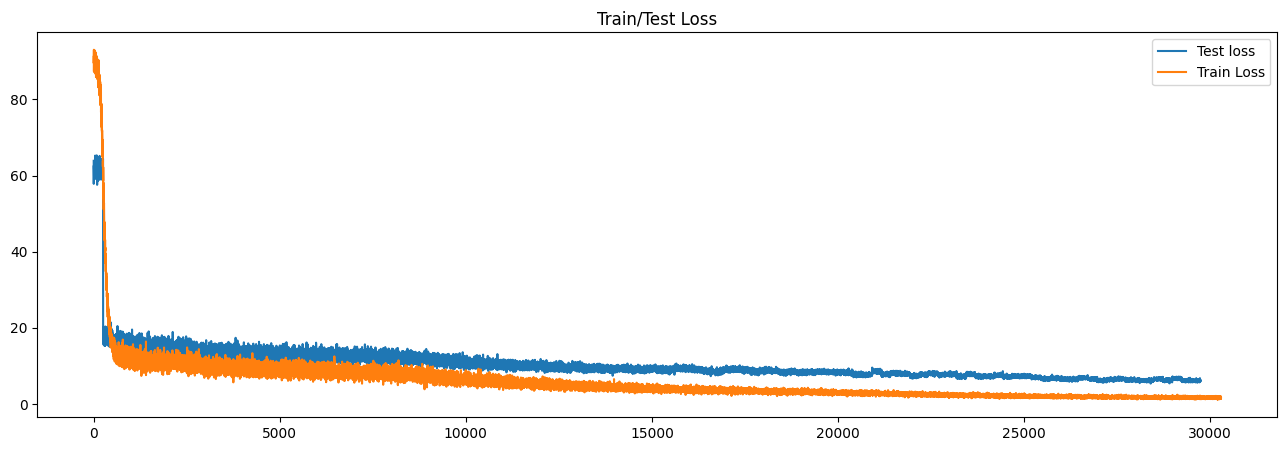

In [17]:
plt.figure(figsize=(16,5))
plt.title("Train/Test Loss")
plt.plot(test_loss, label='Test loss')
plt.plot(train_loss, label='Train Loss')
plt.legend()